# Предсказание качества восстановления золота из руды

В нашем распоряжении данные с параметрами добычи и очистки золотоносной руды. Требуется построить модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды. Нужно спрогнозировать две величины:

 - эффективность обогащения чернового концентрата rougher.output.recovery;
 - эффективность обогащения финального концентрата final.output.recovery.

## Описание данных

Данные находятся в трёх файлах:

- ***gold_recovery_train.csv*** — обучающая выборка;
- ***gold_recovery_test.csv*** — тестовая выборка;
- ***gold_recovery_full.csv*** — исходные данные.

Наименование признаков имеет вид:

*этап.тип_параметра.название_параметра*

Возможные значения для блока *этап*:

- **rougher** — флотация   
- **primary_cleaner** — первичная очистка
- **secondary_cleaner** — вторичная очистка
- **final** — финальные характеристики

Возможные значения для блока *тип_параметра*:

- **input** — параметры сырья
- **output** — параметры продукта
- **state** — параметры, характеризующие текущее состояние этапа
- **calculation** — расчётные характеристики

Данные индексируются датой и временем получения информации (признак **date**). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

## Метрика качества

Для решения задачи используется метрика *sMAPE* (Symmetric Mean Absolute Percentage Error), которая рассчитывается по формуле:

<img src=https://pictures.s3.yandex.net/resources/smape_1576238825.jpg
     width="600"></img>
     
При этом в оценке должны участвовать как финальный, так и черновой концентрат. Итоговая формула для метрики качества выглядит следующим образом:

<img src=https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg
     width="600"></img>



## План выполнения задания

1. Подготовка данных: 
 - Открыть и изучить файлы;
 - Проверить правильность рассчета целевого параметра по формуле;
 - Проанализировать признаки, отсутствующие в тестовой выборке;
 - Произвести предобработку данных.
2. Анализ данных:
 - Проследить изменение концентрации металлов на различных этапах очистки;
 - Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках;
 - Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, обработать аномалии. 
3. Построение модели:
 - Написать функцию измерения требуемой метрики (sMAPE);
 - Обучить разные модели, оценить их качество кросс-валидацией. 
 - Проверить лучшую модель на тестовой выборке.

# 1. Подготовка данных

### Изучение данных

Импортируем необходимые модули:

In [46]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)})

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

Загрузим полученные таблицы и выведем для наглядности несколько строк. В качестве индексов будем использовать столбец **data**:

In [47]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv', 
                         parse_dates = [0], # преобразовать даты в datetime 
                         index_col = 0)     # использовать столбец date в качестве индекса
gold_test  = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates = [0], index_col = 0)
gold_full  = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates = [0], index_col = 0)

display(gold_train.head(3), gold_test.head(3))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


Посмотрим на размеры полученных таблиц:

In [48]:
print(f'''Размер таблицы gold_train: {gold_train.shape},
Размер таблицы gold_test: {gold_test.shape},
Размер таблицы gold_full: {gold_full.shape}.''')

Размер таблицы gold_train: (16860, 86),
Размер таблицы gold_test: (5856, 52),
Размер таблицы gold_full: (22716, 86).


Как можно видеть, таблицы ***gold_train*** и ***gold_full*** содержат по 86 столбцов, а ***gold_test*** - 52 столбца. Проверим типы данных:

In [49]:
print(gold_train.dtypes.unique(), gold_test.dtypes.unique())

[dtype('float64')] [dtype('float64')]


Все столбцы содержат данные в вещественном виде, преобразований не требуется.

Целевыми признаками нашей модели регрессии являются столбцы **rougher.output.recovery** и **final.output.recovery** (эффективность обогащения чернового и итогового концентрата соответственно). Данный параметр зависит от трех величин:
- C - доля золота в сырье/концентрате до флотации/очистки (**rougher.input.feed_au**);
- F - доля золота в концентрате после флотации/очистки (**rougher.output.concentrate_au** и **final.output.concentrate_au**);
- T - доля золота в отвальных хвостах после флотации/очистки (**rougher.output.tail_au** и **final.output.tail_au**),

и рассчитывается по формуле (1):

<img src=https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg
     width="600"></img>
     
Изучим распределение данных параметров:

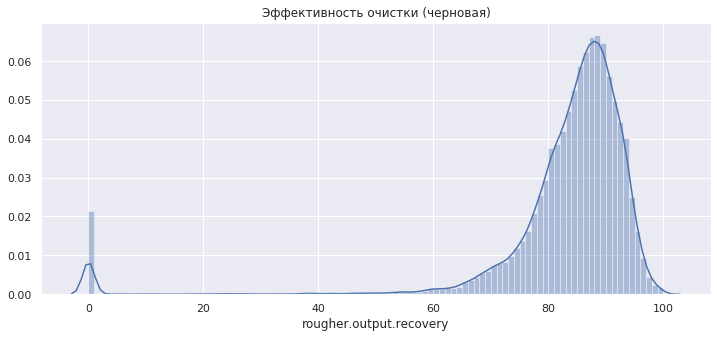

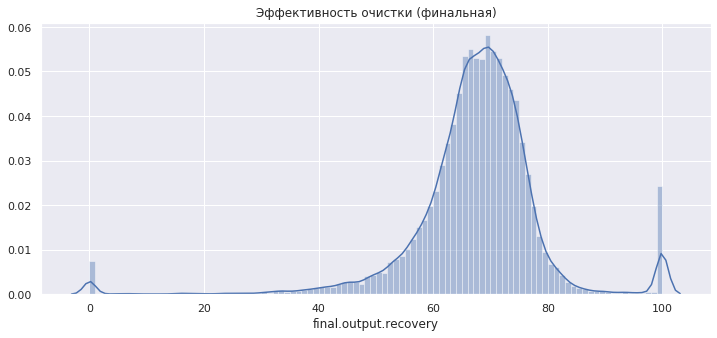

In [50]:
sns.distplot(gold_full['rougher.output.recovery'].dropna(), bins = 100)
plt.title('Эффективность очистки (черновая)')
plt.show()
sns.distplot(gold_full['final.output.recovery'].dropna(), bins = 100)
plt.title('Эффективность очистки (финальная)')
plt.show()

В целом распределение имеет нормальную форму и определено на промежутке от 0 до 100 процентов (что соответсвует ожиданиям). При этом есть аномальные максимумы на 0 и 100 процентах. которые могли быть вызваны ошибками измерений или рассчетов. Как поступить с данными выбросами, решим позже.

###  Правильность рассчета recovery

Проверим, верно ли рассчитана эффективность, на примере **rougher.output.recovery**. Сначала подробнее изучим входящие в эту формулу элементы:

In [51]:
gold_train[['rougher.input.feed_au', 
            'rougher.output.concentrate_au', 
            'rougher.output.tail_au',
            'rougher.output.recovery']].describe()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery
count,16777.000000,16778.000000,14611.000000,14287.000000
mean,7.170717,17.401541,1.763930,82.394201
std,3.002113,6.921875,0.731518,15.096808
min,0.000000,0.000000,0.020676,0.000000
25%,6.203083,17.443663,1.311610,79.818372
50%,7.443530,19.644663,1.747907,85.235997
75%,8.965193,21.224486,2.190839,90.131691
max,14.093363,28.522811,9.688980,100.000000


Мы видим, что во всех этих столбцах присутствуют пропуски, а в **rougher.input.feed_au** и **rougher.output.concentrate_au** еще и нулевые значения, что может привести к ошибкам в расчетах (деление на ноль, отрицательные значения эффективности). Нулевые значения, предположительно, возникают из-за ошибок измерительных приборов (особенно если учесть, что в хвостах они отсутствуют, то есть в каких-то случаях на выходе золота получается больше, чем на входе).

Заполнение пропусков произведем позже, а для проверки правильности рассчета эффективности используем только те записи, где отсутствуют пропуски и нулевые значения:

In [52]:
test_recovery = gold_train.loc[(gold_train['rougher.input.feed_au'] *
                                gold_train['rougher.output.concentrate_au'] * 
                                gold_train['rougher.output.tail_au']) != 0, :].dropna()

Определим функцию, которая будет считать эффективность обогащения по формуле, и запишем ее результаты в столбец **rougher.calculation.recovery**:

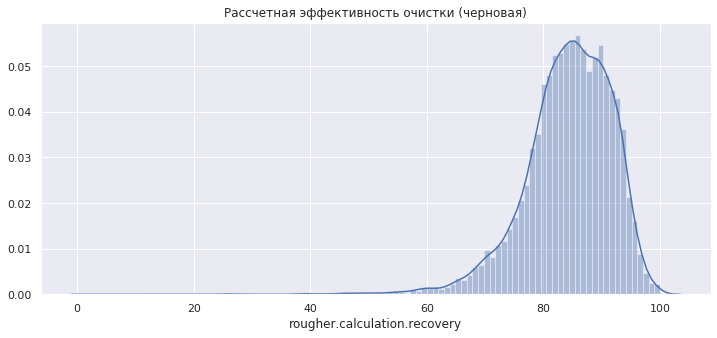

In [53]:
def recovery(row):
    c, f, t = row
    return (c * (f - t)) / (f * (c - t)) * 100

test_recovery['rougher.calculation.recovery'] = test_recovery[['rougher.output.concentrate_au',
                                                               'rougher.input.feed_au',
                                                               'rougher.output.tail_au']].apply(recovery, 
                                                                                                axis = 1)
# Выведем распределение рассчитанной величины
sns.distplot(test_recovery['rougher.calculation.recovery'].dropna(), bins = 100)
plt.title('Рассчетная эффективность очистки (черновая)')
plt.show()

Теперь подсчитаем MAE между рассчитанными значениями и целевым столбцом:

In [54]:
print('Ошибка равна', mean_absolute_error(test_recovery['rougher.calculation.recovery'], 
                                          test_recovery['rougher.output.recovery']))

Ошибка равна 9.736775039790644e-15


Таким образом, можно считать, что значение **recovery** в таблице вычисляется верно.

### Сравнение признаков в тренировочном и тестовом наборах

Как мы видели ранее, в тестовом наборе меньше столбцов, чем в тренировочном. Рассмотрим, какие признаки в нем отсутствуют:

In [55]:
missing_columns = set(gold_train.columns) - set(gold_test.columns) # сохраним список отсутствующих столбцов
print('столбцы, отсутствующие в gold_test:')
missing_columns

столбцы, отсутствующие в gold_test:


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Как видно, в тестовом наборе отсутствуют результаты различных этапов (**output.concentrate**, **output.tails**), а также некоторые рассчетные значения (соотношение разных веществ и материалов). Очевидно, что все выходные величины либо являются составляющими целевых признаков, либо сильно от них зависят, поэтому при построении модели они использоваться не должны. Рассчетные значения также не нужны для анализа, поскольку являются производными от прочих признаков.

### Выделение целевых признаков

Сначала удалим из таблицы ***gold_train*** записи с пропусками в столбцах **rougher.output.recovery** и **final.output.recovery** - для обучения модели они бесполезны:

In [56]:
gold_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)

Также считаем целесообразным отбросить записи с **recovery**, равными *0* и *100*. Как мы видели ранее, данные значения, скорее всего, вызваны ошибками измерений.

In [57]:
gold_train = gold_train.loc[(gold_train['rougher.output.recovery'] *
                             gold_train['final.output.recovery']) != 0, :]
gold_train = gold_train.loc[gold_train['final.output.recovery'] != 100, :]

print(f'Размер таблицы gold_train: {gold_train.shape}')

Размер таблицы gold_train: (13721, 86)


Выделим эти столбцы с целевыми признаками в переменную ***gold_train_target***:

In [58]:
gold_train_target = gold_train[['rougher.output.recovery', 'final.output.recovery']]

В тестовом наборе целевые признаки отсутствуют. Возьмем их их исходного датасета:

In [59]:
gold_test_target = gold_full.loc[gold_test.index, ['rougher.output.recovery', 'final.output.recovery']]

Как и в тренировочном наборе, удалим строки с пропусками целевого признака - проверить правильность предсказаний модели на них не выйдет:

In [60]:
gold_test_target.dropna(inplace = True)
gold_test = gold_test.loc[gold_test_target.index, :] # приведем в соответсвие набор с признаками
print(f'Размер таблицы gold_test: {gold_test.shape}')

Размер таблицы gold_test: (5290, 52)


### Заполнение пропусков

Теперь заполним пропуски в остальных столбцах таблицы. Как известно из задания, соседние по времени записи таблицы, как правило, имеют близкие значения. В связи с этим пропуски можно заполнить соседними значениями соответствующих признаков:

In [61]:
gold_train.fillna(method = 'ffill', inplace = True)
gold_test.fillna(method = 'ffill', inplace = True)

# Вывод

На этом шаге мы произвели предварительное изучение и обработку полученных данных. Нами изучено содержание таблиц, выделены целевые признаки (**recovery** после этапа флотации и финальная) и проверена правильность их рассчета по формуле. После этого мы сравнили набор признаков в тренировочном и тестовом наборах и отмечено, что в последнем отсутствуют столбцы с продуктами различных этапов, что не вызывает вопросов.

Затем мы заполнили пропуски и выделили целевые признаки в отдельную переменную.

# 2. Анализ данных

### Изменение концентрации металлов в сырье

Посмотрим, как изменяется концентрация металлов (Au, Ag, Pb) и твердых примесей (Sol) на различных этапах очистки. Начнем с золота:

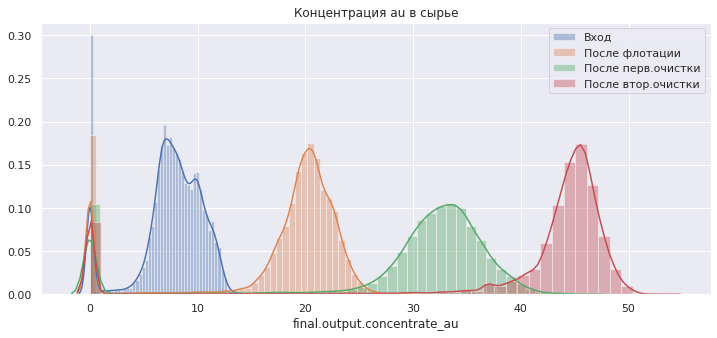

In [62]:
stages = ['rougher.input.feed_', 
          'rougher.output.concentrate_', 
          'primary_cleaner.output.concentrate_' ,
          'final.output.concentrate_']            # этапы обработки

def plot_concentrates(metal):
    for stage in stages:
        stage += metal
        sns.distplot(gold_full[stage].dropna())
    plt.legend(['Вход', 'После флотации', 'После перв.очистки', 'После втор.очистки'])
    plt.title('Концентрация ' + metal + ' в сырье')
    
plot_concentrates('au')

Тут все соответствует ожиданиям - с каждым шагом очистки доля золота в сырье возрастает. 

Теперь посмотрим на серебро:

In [63]:
plot_concentrates('pb')

Содержание свинца в процессе очистки не уменьшается, а даже немного увеличивается - видимо, применяемые методы очистки против данного металла не так эффективны. 

Наконец, изучим доли остальных твердых примесей: 

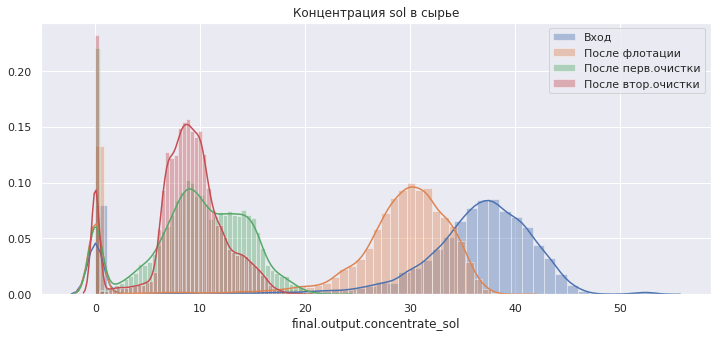

In [65]:
plot_concentrates('sol')

Как и ожидалось, по мере очистки сырья доля примесей значительно уменьшается.

### Распределение размеров гранул сырья на обучающей и тестовой выборках

Сравним размеры гранул сырья в наших выборках. Они должны быть сопоставимы, иначе получится, что обучающая выборка нерепрезентативна, и модель будет работать некорректно.

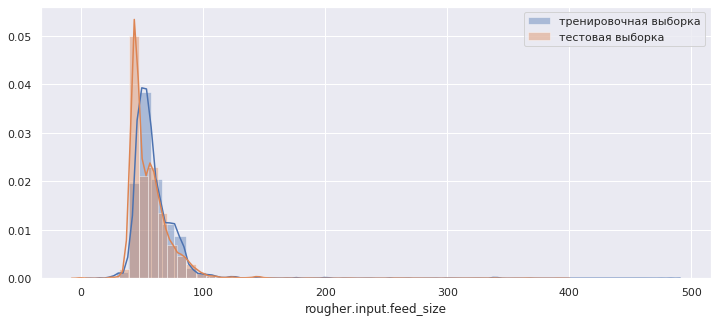

In [66]:
sns.distplot(gold_train['rougher.input.feed_size'].dropna())
sns.distplot(gold_test['rougher.input.feed_size'].dropna())
plt.legend(['тренировочная выборка', 'тестовая выборка'])
plt.show()

Распределения в целом совпадают, также можно отметить, что в обеих выборках есть немногочисленные выбросы.
Теперь рассмотрим размер гранул сырья после флотации:

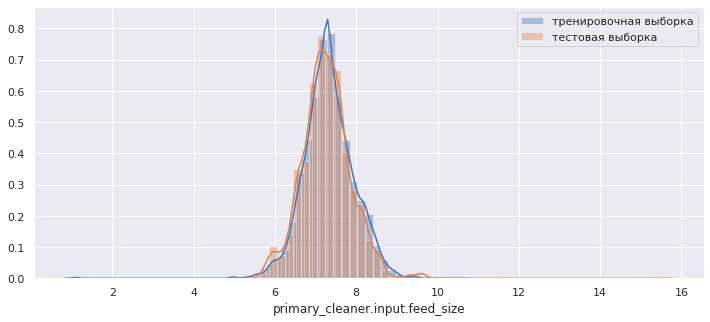

In [67]:
sns.distplot(gold_train['primary_cleaner.input.feed_size'].dropna())
sns.distplot(gold_test['primary_cleaner.input.feed_size'].dropna())
plt.legend(['тренировочная выборка', 'тестовая выборка'])
plt.show()

Тут также имеем совпадение.

### Cуммарная концентрация веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях очистки на предмет наличия аномалий (например, суммарной доли, превышающей 100 процентов). Построим график распределения для каждого этапа:

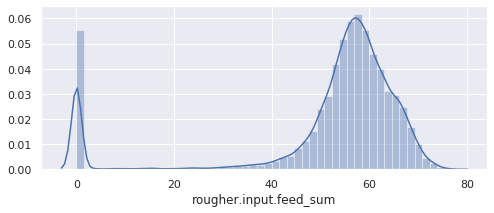

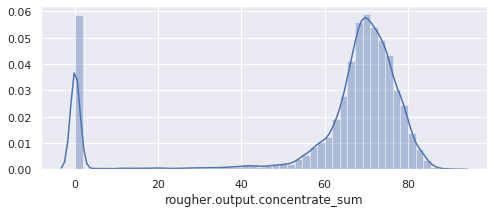

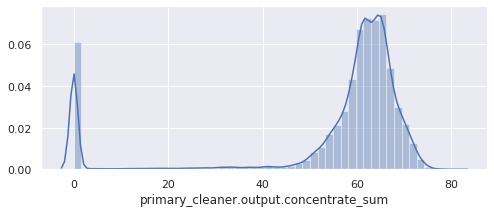

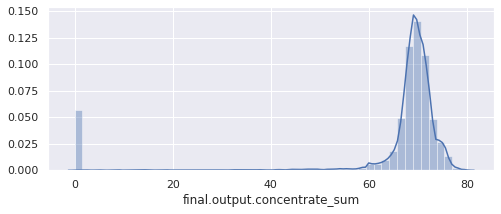

In [68]:
sns.set(rc={'figure.figsize':(8, 3)})
for stage in stages:
    gold_full[stage + 'sum'] = (gold_full[stage + 'au'] + 
                                gold_full[stage + 'ag'] +
                                gold_full[stage + 'pb'] + 
                                gold_full[stage + 'sol'])
    
    sns.distplot(gold_full[stage + 'sum'].dropna())
    plt.show()

Видим следующее:
- Суммарная доля всех указанных веществ составляет менее 100 процентов, что нормально - возможно, в таблице отсутствуют данные о каких-то дополнительных примесях.
- На каждом этапе присутствует пик на значении 0, что является аномалией. Как обсуждалось ранее, нулевые значения скорее всего возникают при неисправностях и ошибках приборов.

Для нашей модели имеет значение только столбцы **rougher.input.feed_** (концентрации металлов на выходах различных этапов отсутствуют в тестовом наборе и использоваться при построении модели не будут). Считаем целесообразным заполнить их по аналогии с пропусками (соседними ненулевыми значениями):

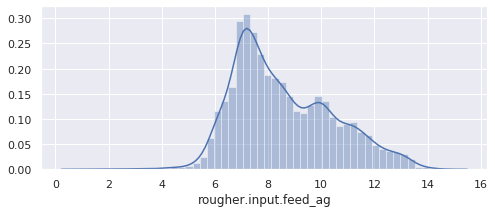

In [69]:
for dataset in gold_train, gold_test:
    dataset[['rougher.input.feed_ag', 
             'rougher.input.feed_pb', 
             'rougher.input.feed_sol', 
             'rougher.input.feed_au']].replace(0, method = 'ffill', inplace = True)

sns.distplot(gold_train['rougher.input.feed_ag']) #проверка
plt.show()

# Вывод

На данном этапе нами произведен исследовательский анализ данных:
- Мы изучили изменение концентраций различных металлов на разных этапах. Полученный результат соответствует ожидаемому: по мере очистки сырья доля золота возрастает, а остальных металлов и примесей - уменьшается.
- Сравнили распределение размеров гранул сырья в тестовой и тренировочной выборках. Они совпали, из чего сделан вывод о том, что тренировочная выборка достаточно репрезентативна по этому признаку.
- Найдена суммарная концентрация всех веществ на каждом этапе цикла, в результате чего обнаружен аномальный максимум в значении 0. Поскольку для обучения модели мы будем использовать только входные параметры, в соответствующих столбцах нули заполнены соседними ненулевыми значениями.

# 3. Построение модели

Целевые признаки, которые нам нужно предсказывать - количественные, соответственно требуется решить задачу регрессии. При этом для предсказания эффективности очистки после флотации логично использовать только те признаки, которые доступны на данный момент (не использовать данные о последующих этапах). Для предсказания финальной эффективности будем использовать все признаки, которые содержатся в тестовом наборе (лишние столбцы исключим из тренировочной выборки).

### Подготовка данных

Уберем из тренировочной выборки столбцы, отсутствующие в тестовом наборе:

In [70]:
gold_train = gold_train.drop(columns = list(missing_columns))
print('Размер тренировочной выборки: ',gold_train.shape)

Размер тренировочной выборки:  (13721, 52)


Поскольку нам необходимо предсказать два признака, которые появляются на разных этапах обработки сырья, считаем целесообразным использовать две модели, которые будут обучаться на различных наборах признаков.

Сначала подготовим тренировочный и тестовый набор для регрессии **rougher.output.recovery**. Логично предположить, что на нее влияют только параметры, измеренные до завершения флотации, а использовать данные "из будущего" неправильно. Сохраним в отдельные переменные только те признаки, которые относятся к этапу флотации:

In [71]:
rougher_feats_list = [x for x in gold_train.columns if 'rougher' in x] #только столбцы с "rougher" в названии
rougher_train = gold_train[rougher_feats_list]
rougher_test  = gold_test[rougher_feats_list]
print('Размеры полученных подвыборок: тренировочная:', rougher_train.shape, 
      ', тестовая: ', rougher_test.shape)     #проверка

Размеры полученных подвыборок: тренировочная: (13721, 22) , тестовая:  (5290, 22)


Что касается предсказания итоговой эффективности, то считаем разумным отбросить признаки, относящиеся к этапу флотации, и добавить вместо них столбец с рассчитанными значениями **rougher.output.recovery**. При этом исходим из следующих предположений:
- Параметры флотации намного меньше влияют на итоговую recovery, чем на первичную;
- Уменьшение количества признаков упростит построение модели, при этом информация о них потеряна не будет, поскольку она содержится в рассчитанной **rougher.output.recovery**.

подготовим наборы для обучения и тестирования второй модели:

In [72]:
final_train = gold_train.drop(columns = rougher_feats_list)
final_test = gold_test.drop(columns = rougher_feats_list)
print('Размеры полученных подвыборок: тренировочная:', final_train.shape, 
      ', тестовая: ', final_test.shape)     #проверка

Размеры полученных подвыборок: тренировочная: (13721, 30) , тестовая:  (5290, 30)


### Формула для вычисления метрики sMAPE

Напишем формулу для нахождения заданной метрики качества:

In [73]:
def smape(true, pred):
    '''Вспомогательная функция для вычисления smape'''
    score = sum(abs(true - pred) / ((abs(true) + abs(pred)) / 2)) / len(pred) * 100
    return score

smape_scorer = make_scorer(smape, greater_is_better = False) # scorer для передачи в качестве параметра в кросс-валидатор

Итоговая sMAPE складывается из оценки эффективности для чернового и финального концентрата. Она будет вычисляться с помощью следующей функции:

In [74]:
def result_smape(r_smape, f_smape):
    return 0.25 * r_smape + 0.75 * f_smape

### dummy-модель

Для оценки качества наших моделей и их проверки "на вменяемость" применим сперва некоторый примитивный регрессор, с которым и будем сравнивать наши полученные результаты. Для этого воспользуемся dummy-регрессором из библиотеки scikit-learn, который будет вне зависимости от признаков возвращать медиану целевого параметра:

In [91]:
base_model = DummyRegressor(strategy = 'median')
dummy_score_1 = cross_val_score(base_model, rougher_train, gold_train_target['rougher.output.recovery'], 
                            scoring = smape_scorer,
                            cv = 3,
                            n_jobs = -1)
print('При регрессии rougher.output.recovery на кросс-валидации получили sMAPE', -1 * dummy_score_1.mean())

dummy_score_2 = cross_val_score(base_model, final_train, gold_train_target['final.output.recovery'], 
                            scoring = smape_scorer,
                            cv = 3,
                            n_jobs = -1)

print('При регрессии final.output.recovery на кросс-валидации получили sMAPE', -1 * dummy_score_2.mean())

При регрессии rougher.output.recovery на кросс-валидации получили sMAPE 8.750578769723814
При регрессии final.output.recovery на кросс-валидации получили sMAPE 10.708288779933218


Получили следующие значения на кросс-валидации:
- для эффективности после флотации - 7.81 процента;
- для эффективности финальной очистки - 10.28 процента.

Соответственно, наши модели должны показывать результаты не хуже указанных.

### Выбор и обучение моделей

В качестве алгоритмов регрессии рассмотрим следующие:
- Случайный лес;
- Линейную регрессию;
- SVM.

#### 1. rougher.output.recovery

Начнем с предсказания **recovery** после флотации. Сначала произведем нормирование признаков в тренировочном и тестовом наборе:

In [76]:
scaler = StandardScaler()
scaler.fit(rougher_train)
rougher_train = scaler.transform(rougher_train)
rougher_test  = scaler.transform(rougher_test)

Построим три модели и найдем для каждой метрику sMAPE при кросс-валидации на тренировочных данных (количество фолдов выберем равным 5):

In [77]:
# выполняется долго
# linreg_model = LinearRegression()
# lr_score = cross_val_score(linreg_model, rougher_train, gold_train_target['rougher.output.recovery'], 
#                            scoring = smape_scorer,
#                            cv = 5,
#                            n_jobs = -1)
# print('Для модели Линейная регрессия sMAPE при кросс-валидации равно', lr_score.mean() * (-1))

# forest_model = GridSearchCV(RandomForestRegressor(random_state = 321), 
#                             param_grid = {'n_estimators': [50, 100, 300],
#                                           'max_depth': [10, 15, 30]}, 
#                             scoring = smape_scorer, 
#                             cv = 5)                           # подберем гиперпараметры по сетке
# forest_model.fit(rougher_train, gold_train_target['rougher.output.recovery'])
# print('Для Cлучайного Леса sMAPE равно', forest_model.best_score_ * (-1), 
#       'при параметрах', forest_model.best_params_)            # В GridSearch кросс-валидация происходит 
#                                                               # при подборе параметров                        
    
# supvect_model = GridSearchCV(SVR(),
#                              param_grid = {'C': [0.1, 0.5, 1],
#                                            'gamma': [0.001, 0.01, 0.1]}, 
#                              scoring = smape_scorer, 
#                              cv = 5)
# supvect_model.fit(rougher_train, gold_train_target['rougher.output.recovery'])
# print('Для SVR sMAPE равно', supvect_model.best_score_ * (-1), 
#       'при параметрах', supvect_model.best_params_)

Наименьшую ошибку показал алгоритм на основе опорных векторов c параметрами C = 0.1, gamma = 0.01. Ее величина составила 6.10 процента, что почти на 2 процента (в 1.3 раза) меньше, чем на базовой модели. Подготовим с помощью этой модели предсказания черновой эффективности очитстки для тренировочного и тестового набора:

In [78]:
rougher_model = SVR(gamma = 0.01, C = 0.1)
rougher_model.fit(rougher_train, gold_train_target['rougher.output.recovery']) # обучим на всех данных
train_rougher_recovery_pred = rougher_model.predict(rougher_train)
test_rougher_recovery_pred  = rougher_model.predict(rougher_test)

#### final.output.recovery

Теперь аналогичным способом подберем регрессор для итоговой эффективности. Сначала подставим в наборы признаков предсказанные на предыдущем шаге значения:

In [79]:
final_train['rougher.pred.recovery'] = train_rougher_recovery_pred
final_test['rougher.pred.recovery'] = test_rougher_recovery_pred

Нормируем признаки:

In [80]:
scaler.fit(final_train)
final_train = scaler.transform(final_train)
final_test  = scaler.transform(final_test)

Построим модели и найдем sMAPE на кросс-валидации с числом фолдов, равным 5 (аналогично предыдущему пункту):

In [81]:
# выполняется очень долго)
# linreg_model = LinearRegression()
# lr_score = cross_val_score(linreg_model, final_train, gold_train_target['final.output.recovery'], 
#                            scoring = smape_scorer,
#                            cv = 5,
#                            n_jobs = -1)
# print('Для модели Линейная регрессия sMAPE при кросс-валидации равно', lr_score.mean() * (-1))

# forest_model = GridSearchCV(RandomForestRegressor(random_state = 321), 
#                             param_grid = {'n_estimators': [50, 100, 300, 500],
#                                           'max_depth': [10, 15, 30]}, 
#                             scoring = smape_scorer, 
#                             cv = 5)                           # подберем гиперпараметры по сетке
# forest_model.fit(final_train, gold_train_target['final.output.recovery'])
# print('Для Cлучайного Леса sMAPE равно', forest_model.best_score_ * (-1), 
#       'при параметрах', forest_model.best_params_)            # В GridSearch кросс-валидация происходит 
#                                                               # при подборе параметров                        
    
# supvect_model = GridSearchCV(SVR(),
#                              param_grid = {'C': [0.1, 0.5, 1],
#                                            'gamma': [0.001, 0.01, 0.1]}, 
#                              scoring = smape_scorer, 
#                              cv = 5)
# supvect_model.fit(final_train, gold_train_target['final.output.recovery'])
# print('Для SVR sMAPE равно', supvect_model.best_score_ * (-1), 
#       'при параметрах', supvect_model.best_params_)

В данном случае лучший результат также показала модель SVM (значение sMAPE - 8.79 процента). Обучим ее на всем тренировочном наборе и найдем **final.output.recovery** для тестового набора:

In [82]:
final_model = SVR(gamma = 0.001, C = 0.1)
final_model.fit(gold_train, gold_train_target['final.output.recovery'])
test_final_recovery_pred = final_model.predict(gold_test)

Наконец, рассчитаем sMAPE для обоих целевых признаков, а также итоговую метрику:

In [83]:
rougher_smape = smape(test_rougher_recovery_pred, gold_test_target['rougher.output.recovery'])
final_smape =   smape(test_final_recovery_pred, gold_test_target['final.output.recovery'])

print('sMAPE эффективности очистки после флотации:', rougher_smape)     
print('sMAPE финальной эффективности очистки:', final_smape)     
print('Итоговое значение метрики sMAPE:', result_smape(rougher_smape, final_smape))

sMAPE эффективности очистки после флотации: 7.517426747936318
sMAPE финальной эффективности очистки: 9.726324588331828
Итоговое значение метрики sMAPE: 9.17410012823295


Итоговое значение метрики - 9.17 процента. Сравним его с константной моделью. Рассчитаем итоговое sMAPE для dummy-модели на тестовых данных:

In [94]:
dummy_result_smape = result_smape(dummy_score_1, dummy_score_2) #рассчитаны выше
print('Итоговое значение sMAPE для константной модели:', dummy_result_smape.mean() * (-1))

Итоговое значение sMAPE для константной модели: 10.218861277380867


Как можно видеть, sMAPE наших моделей (9.17) меньше константной модели (10.22), хоть и не намного.

# Вывод

На данном этапе мы подобрали и обучили различные модели регрессии для предсказания значений целевых признаков. Наилучшие результаты показал алгоритм на основе машин опорных векторов, итоговое значение целевой метрики (sMAPE) для них составило 9.17 процента.